### Load libraries

In [167]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error

### Read in DF

In [168]:
all_df = pd.read_msgpack('feature_df___w_mp.mp')

### Subset train df

Only between certain years, not rookie, change in BPM is not null (only if predicting delta)

In [169]:
train_df = all_df[
    (all_df['year'] > 1970) 
    & (all_df['year'] < 2015) 
    & (all_df['years_pro'] > 0) 
    &(all_df['diff'].notnull())
]

### Some LGB params

In [170]:

lgb_params = {
    'boosting_type': 'gbdt',
    'metric': ['rmse'],
    #'num_leaves': 20,
    'learning_rate': 0.05,
    #'feature_fraction': 0.6,
    #'bagging_fraction': 0.6,
    #'bagging_freq': 1,
    #'bagging_freq': 5,
    #'colsample_bytree': .4,
    #'min_data_in_leaf': 2,
    #'reg_alpha': 1,
    #'reg_lambda': 1,
    #'max_depth': 4,
    'verbose': 0
}

### Define X, y, drop any lookahead features

In [243]:
y_diff = train_df['diff']
y = train_df['bpm']
drop_cols =['id', 'ws', 'bpm', 'player_url', 'year', 'mp', 'diff', 'started_team', 'pos']
X = train_df.drop(drop_cols, 1).astype(float)
X_all = all_df.drop(drop_cols, 1).astype(float)

### Define out-of-sample generator

In [174]:
from sklearn.model_selection import KFold
def get_out_of_sample(X, y, weights):
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    all_preds = []
    all_models = []
    for train_index, test_index in kf.split(X):
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        weights_test = weights.iloc[test_index]
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        weights_train = weights.iloc[train_index]
        lgb_data = lgb.Dataset(X_train, y_train, weight=weights_train)
        out = lgb.cv(lgb_params, lgb_data, num_boost_round=10000, nfold=5,
                     early_stopping_rounds=10,stratified=False)
        cv_loss = out['rmse-mean'][-1]
        cv_num_rounds = len(out['rmse-mean'])
        bst = lgb.LGBMRegressor(n_estimators=cv_num_rounds, **lgb_params)
        bst.fit(X_train, y_train, sample_weight=weights_train)
        preds = pd.Series(bst.predict(X_test), index=test_index)
        all_preds.append(preds)
        all_models.append(bst)
    return all_preds, all_models

### When training, care more about players with more minutes

Better actual estimate for their BPM

In [175]:
weights = np.log10(train_df['mp']+1) #* 0 + 1

In [176]:
diff_preds, diff_models = get_out_of_sample(X, y_diff, weights)

In [177]:
full_preds, full_models = get_out_of_sample(X, y, weights)

### Stacking

In [235]:
pred_df = train_df.copy()
diff_pred_series = pd.concat(diff_preds).sort_index()
full_pred_series = pd.concat(full_preds).sort_index()

In [236]:
pred_df['yhat_diff'] = diff_pred_series.values
pred_df['pred_full'] = full_pred_series.values
pred_df['pred_diff'] = pred_df['bpm___1'] + pred_df['yhat_diff']

In [237]:
mean_squared_error(pred_df['bpm'], pred_df['pred_diff'])

8.924672146089096

In [238]:
mean_squared_error(pred_df['bpm'], pred_df['pred_full'])

8.283405109189257

In [245]:
stacked_cols = ['mp___1', 'age', 'pred_full', 'pred_diff', 'mp___2', 'mp___3', 'years_pro', 'yhat_diff', 'bpm___1']

In [246]:
X_stacked = pred_df[stacked_cols]
X_stacked['arb_line'] = (X_stacked['mp___1'] > 200) & (X_stacked['age'] == 25) 

/Users/harrisonchase/workplace/.venvs/record_linking/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [247]:
lgb_data = lgb.Dataset(X_stacked, y, weight=weights)
out = lgb.cv(lgb_params, lgb_data, num_boost_round=10000, nfold=5,
             early_stopping_rounds=10,stratified=False)
cv_loss = out['rmse-mean'][-1]
cv_num_rounds = len(out['rmse-mean'])
cv_loss, cv_num_rounds

(2.2911996945211, 70)

In [248]:
bst_stacked = lgb.LGBMRegressor(n_estimators=cv_num_rounds, **lgb_params)
bst_stacked.fit(X_stacked, y, sample_weight=weights)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              metric=['rmse'], min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=70, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=0)

### Predict and transform back to BPM prediction

In [249]:
all_full_preds = []
for bst in full_models:
    all_full_preds.append(bst.predict(X_all))

In [250]:
all_diff_preds = []
for bst in diff_models:
    all_diff_preds.append(bst.predict(X_all))

In [251]:
all_full_pred_series = pd.DataFrame(all_full_preds).T.mean(axis=1)

In [252]:
all_diff_pred_series = pd.DataFrame(all_diff_preds).T.mean(axis=1)

In [253]:
all_pred_df = all_df.copy()
all_pred_df['pred_full'] = all_full_pred_series.values
all_pred_df['yhat_diff'] = all_diff_pred_series.values
all_pred_df['pred_diff'] = all_pred_df['yhat_diff'] + all_pred_df['bpm___1']

In [254]:
X_stacked_all = all_pred_df[stacked_cols]
X_stacked_all['arb_line'] = (X_stacked_all['mp___1'] > 200) & (X_stacked_all['age'] == 25) 

/Users/harrisonchase/workplace/.venvs/record_linking/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [255]:
preds = bst_stacked.predict(X_stacked_all)

In [256]:
all_pred_df['pred'] = preds

### Look at predictions for recent year

In [257]:
recent = all_pred_df[(all_pred_df['year'] >= 2015) & (all_pred_df['year'] < 2020)].sort_values('pred')
recent = all_pred_df[(all_pred_df['year'] == 2020)].sort_values('pred', ascending=False)
recent = recent[(recent['years_pro'] > 0)]

In [258]:
recent

,player_url,year,ws,id,bpm,mp,age,pick_overall,C,F,...,team_mp___1,team_mp___1_new,team_mp___1_returning,pos_team_mp___1,pos_team_mp___1_new,pos_team_mp___1_returning,pred_full,yhat_diff,pred_diff,pred
18178,/players/a/antetgi01.html,2020,NaN,/players/a/antetgi01.html___2020,NaN,NaN,25,15.0,0,0,...,20683.0,3126.0,14164.0,5297.0,826.0,4471.0,8.211868,-3.251956,7.548044,8.209841
18298,/players/h/hardeja01.html,2020,NaN,/players/h/hardeja01.html___2020,NaN,NaN,30,3.0,0,0,...,19081.0,2788.0,13390.0,5497.0,2630.0,2867.0,8.277122,-2.343265,9.356735,7.970137
18248,/players/d/davisan02.html,2020,NaN,/players/d/davisan02.html___2020,NaN,NaN,26,1.0,1,0,...,19688.0,7926.0,9857.0,4292.0,2621.0,1671.0,6.861915,-1.708077,6.791923,7.598471
18339,/players/j/jokicni01.html,2020,NaN,/players/j/jokicni01.html___2020,NaN,NaN,24,41.0,1,0,...,20847.0,2663.0,18184.0,4235.0,NaN,4235.0,7.858491,-0.394570,9.105430,7.282467
18335,/players/j/jamesle01.html,2020,NaN,/players/j/jamesle01.html___2020,NaN,NaN,35,1.0,0,0,...,19688.0,7926.0,9857.0,1937.0,NaN,1937.0,7.219923,-1.201214,6.898786,6.280880
18286,/players/g/goberru01.html,2020,NaN,/players/g/goberru01.html___2020,NaN,NaN,27,27.0,1,0,...,20695.0,10065.0,10630.0,4059.0,1446.0,2613.0,5.605940,-1.527465,5.472535,6.068767
18467,/players/t/townska01.html,2020,NaN,/players/t/townska01.html___2020,NaN,NaN,24,1.0,1,0,...,16221.0,5375.0,9643.0,3576.0,NaN,3576.0,6.045356,-0.431540,6.368460,5.501981
18246,/players/c/curryst01.html,2020,NaN,/players/c/curryst01.html___2020,NaN,NaN,31,7.0,0,0,...,17562.0,6076.0,10111.0,4779.0,2448.0,2331.0,5.297716,-1.275257,5.024743,5.041970
18363,/players/l/lillada01.html,2020,NaN,/players/l/lillada01.html___2020,NaN,NaN,29,6.0,0,0,...,16842.0,5618.0,8795.0,2854.0,16.0,2838.0,5.239601,-0.396423,5.103577,5.038917
18488,/players/w/westbru01.html,2020,NaN,/players/w/westbru01.html___2020,NaN,NaN,31,4.0,0,0,...,19081.0,2788.0,13390.0,5497.0,2630.0,2867.0,5.079371,-0.843204,5.656796,5.000996


In [196]:
missing = recent[recent['bpm___1'].isnull()]
regular = recent[recent['bpm___1'].notnull()]

In [197]:
mean_squared_error(missing['bpm'], missing['pred_full'])

69.45269401162521

In [198]:
mean_squared_error(missing['bpm'], missing['pred'])

67.39891704557164

In [199]:
mean_squared_error(regular['bpm'], regular['pred_full'])

8.137260106614631

In [200]:
mean_squared_error(regular['bpm'], regular['pred_diff'])

10.258788847969097

In [201]:
mean_squared_error(regular['bpm'], regular['pred'])

8.09456590292081

### Look into data!!

In [212]:
recent1 = recent.copy()

In [213]:
from sklearn.metrics import mean_squared_error

In [222]:
merged = recent1[['id', 'bpm___1', 'mp___1', 'age', 'pred', 'bpm', 'pred_diff', 'pred_full']].merge(recent[['id', 'pred']], how='left', on='id')

In [223]:
merged_non_null = merged.dropna(subset=['pred_x', 'pred_y'])

In [224]:
mask = (merged_non_null['mp___1'] > 200) & (merged_non_null['age'] == 25) #& ((merged_non_null['age'] > 20))

In [225]:
x = merged_non_null[mask]
y = merged_non_null[~mask]

In [226]:
mean_squared_error(x['bpm'], x['pred_diff'])

5.099579375797721

In [227]:
mean_squared_error(x['bpm'], x['pred_full'])

5.033571111371002

In [220]:
mean_squared_error(y['bpm'], y['pred_x'])

10.73930836556481

In [221]:
mean_squared_error(y['bpm'], y['pred_y'])

10.73930836556481

In [233]:
zs = []
for age in range(20, 38):
    mask = (merged_non_null['mp___1'] > 300) & (merged_non_null['age'] == age) #& ((merged_non_null['age'] > 20))
    x = merged_non_null[mask]
    y = merged_non_null[~mask]
    z = mean_squared_error(x['bpm'], x['pred_x']) - mean_squared_error(x['bpm'], x['pred_y'])
    zs.append(z)

In [234]:
%matplotlib inline

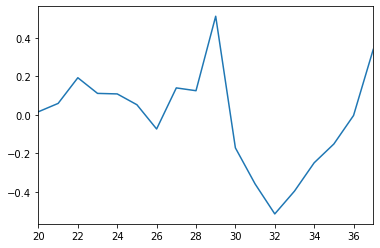

In [235]:
pd.Series(zs, index=range(20,38)).plot()

In [704]:
def max_bpm(row):
    return row[['bpm___1', 'bpm___2', 'bpm___3']].max()

In [705]:
recent['delta'] = recent['pred'] - recent.apply(max_bpm, axis=1)* 1

In [706]:
recent.sort_values('delta', ascending=False)[lambda x: x['pred'] > .5]

,player_url,year,ws,id,bpm,mp,age,pick_overall,C,F,...,mp_diff,bpm_int,bpm_diff_2,bpm_age_int,diff,pred_full,yhat_diff,pred_diff,pred,delta
21274,/players/g/gilgesh01.html,2020,3.3,/players/g/gilgesh01.html___2020,-0.3,2174,21,11.0,0,0,...,NaN,NaN,NaN,-6.3,0.0,0.423441,0.764131,0.464131,0.505173,0.805173
21139,/players/a/aytonde01.html,2020,5.8,/players/a/aytonde01.html___2020,0.2,2183,21,1.0,1,0,...,NaN,NaN,NaN,4.2,0.0,0.901359,0.785242,0.985242,0.954825,0.754825
21335,/players/j/jacksja02.html,2020,3.3,/players/j/jacksja02.html___2020,0.1,1515,20,4.0,0,0,...,NaN,NaN,NaN,2.0,0.0,0.485060,0.628590,0.728590,0.765176,0.665176
21127,/players/a/allenja01.html,2020,7.6,/players/a/allenja01.html___2020,2.5,2096,21,22.0,1,0,...,655.0,0.50,NaN,52.5,0.0,2.511035,-0.110771,2.389229,2.939637,0.439637
21262,/players/f/foxde01.html,2020,5.6,/players/f/foxde01.html___2020,1.1,2546,22,5.0,0,0,...,520.0,-4.84,NaN,24.2,0.0,1.471061,0.303991,1.403991,1.403244,0.303244
21239,/players/d/doncilu01.html,2020,4.9,/players/d/doncilu01.html___2020,4.1,2318,20,3.0,0,0,...,NaN,NaN,NaN,82.0,0.0,3.634287,0.638219,4.738219,4.336556,0.236556
21173,/players/b/bookede01.html,2020,3.5,/players/b/bookede01.html___2020,0.8,2242,23,13.0,0,0,...,377.0,0.32,2.7,18.4,0.0,0.727663,-0.018841,0.781159,0.985310,0.185310
21541,/players/w/whitede01.html,2020,3.6,/players/w/whitede01.html___2020,0.9,1728,25,29.0,0,0,...,1589.0,0.45,NaN,22.5,0.0,0.559020,-0.160955,0.739045,0.905460,0.005460
21277,/players/g/gordoaa01.html,2020,5.1,/players/g/gordoaa01.html___2020,1.0,2633,24,4.0,0,0,...,724.0,0.00,0.7,24.0,0.0,0.728823,-0.134171,0.865829,0.967520,-0.032480
21209,/players/c/collijo01.html,2020,6.0,/players/c/collijo01.html___2020,1.4,1829,22,19.0,0,0,...,44.0,2.38,NaN,30.8,0.0,1.646011,0.428990,1.828990,1.639656,-0.060344
